<a href="https://colab.research.google.com/github/Deveshq/Msc-Project/blob/main/AS_Entanglement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entanglement & Bell State Prepration
    (Neutral Atom Quantum Computing Simulation)

> _Devesh Kumar          
> MSc Physics        
> IIT Roorkee_

In this notebook, we are going to simulate preparation of Bell-states using AS-CNOT pulse sequence.

In [12]:
#Some general imports
import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt

#Some imports from pulser
import pulser
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.waveforms import BlackmanWaveform, ConstantWaveform
from pulser.simulation import Simulation, SimConfig

#Other imports
import qutip
from qutip import bell_state, Qobj, fidelity, basis, tensor

from qiskit.quantum_info import *
from qiskit.visualization import *

## Defining Register
The Register defines the positions of the atoms and their names. Here we've two atoms seprated by a distance of $6 \mu m$, named `Control` and `Target` for 'control' and 'target' respectively.

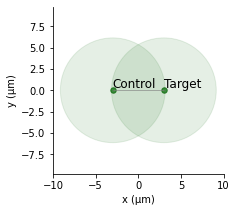

In [17]:
qubits = {'Control': (-3,0) , 'Target': (3,0) }

Omega_max = pi/2
blockade_radius = Chadoq2.rydberg_blockade_radius(Omega_max)

reg = Register(qubits)
reg.draw(blockade_radius=blockade_radius, 
         draw_half_radius=True, draw_graph = True)


## State preparation
This part of sequence corresponds to preparing the different states on which the CNOT gate will act. First we define a function which generate the ket corressponing to given state.

In [18]:
def state_prep(sid, basis):
    ids = {'digital': 'ge', 'ground-rydberg': 'rg', 'all': 'rge'}
    
    ket = {k: qutip.basis(len(ids[basis]), i) 
           for i, k in enumerate(ids[basis])}
    
    return qutip.tensor([ket[x] for x in sid])

Let's check, how the state preparation function working,

In [19]:
state = state_prep('ge', 'digital')
print(state)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]


It generates corrects state. Now we need to define pulse sequence for preparing the state. For this, we define the following Pulse instances:

In [20]:
pi_wf = BlackmanWaveform(200, np.pi)
pi_y = Pulse.ConstantDetuning(pi_wf, 0, -np.pi/2)

In [21]:
def prep_seq(sid, reg):
    global seq
    
    seq = Sequence(reg, Chadoq2)

    #Declare channel
    seq.declare_channel('raman', 'raman_local')
    seq.declare_channel('ryd', 'rydberg_local', 'Control')
    
    if len(sid) != len(reg.qubits):
        raise ValueError('Not a valid state ID.')
    
    seq_dict = {'1':'Target', '0':'Control'}
    
    basis = 'digital'
    if sid == 'gg':
        seq.target('Control', 'raman')
    else:
        for i in range(len(reg.qubits)):
            if sid[i] == 'e':
                seq.target(seq_dict[str(i)],'raman')
                seq.add(pi_y,'raman')
        
    prep_state = state_prep(sid, basis)
            
    return prep_state

## Entanglement Sequence
Our state preparation part has been completed. Now we define pulse sequence for the bell-pair.

In [22]:
half_pi_wf = BlackmanWaveform(100, np.pi/2)
half_pi_pulse = Pulse.ConstantDetuning(half_pi_wf, 0, -np.pi/2)
half_pi_pulse_d = Pulse.ConstantDetuning(half_pi_wf, 0, np.pi/2)

pi_wf = BlackmanWaveform(200, np.pi)
pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)

twopi_wf = BlackmanWaveform(300, 2*np.pi)
twopi_pulse = Pulse.ConstantDetuning(twopi_wf, 0, 0)



Let's define a function which takes state id as input, prepare the state and applies Hadamard & CZ-CNOT sequences.

In [23]:
def ENT(int_id):

    #State Preparation
    prep_state = prep_seq(int_id, reg)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default = 0)
    
    #Hadamard sequence
    seq.target('Control', 'raman')
    seq.add(half_pi_pulse, 'raman', 'wait-for-all')
    seq.align('raman', 'ryd')
    
    #CNOT sequence:
    
    seq.target('Target', 'raman')
    seq.add(pi_pulse, 'ryd')
    seq.target('Target', 'ryd')    # Changes to target qubit
    
    seq.add(pi_pulse, 'ryd')
    seq.align('raman', 'ryd')

    seq.add(pi_pulse, 'raman')
    seq.align('raman', 'ryd')
    
    seq.add(pi_pulse, 'ryd')
    seq.align('raman', 'ryd')
    
    seq.add(pi_pulse, 'raman')
    seq.align('raman', 'ryd')
    
    seq.add(pi_pulse, 'ryd')
    seq.target('Control', 'ryd')     # Changes back to control qubit
    seq.add(pi_pulse, 'ryd')
    
    seq.measure(basis = 'digital')
    
    return prep_state, prep_time

## Visualizing the Sequence
Sequence for the input state |00⟩:


Prepared state-


<IPython.core.display.Latex object>


Preparation time: 0ns

Sequence:-
Channel: raman
t: 0 | Initial targets: Control | Phase Reference: 0.0 
t: 0->100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=4.71) | Targets: Control
t: 100->220 | Target: Target | Phase Reference: 0.0
t: 220->500 | Delay 
t: 500->700 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: Target
t: 700->900 | Delay 
t: 900->1100 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: Target

Channel: ryd
t: 0 | Initial targets: Control | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->300 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: Control
t: 300->300 | Target: Target | Phase Reference: 0.0
t: 300->500 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: Target
t: 500->700 | Delay 
t: 700->900 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: Target
t: 900->1100 | Delay 
t: 1100->1300 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 r

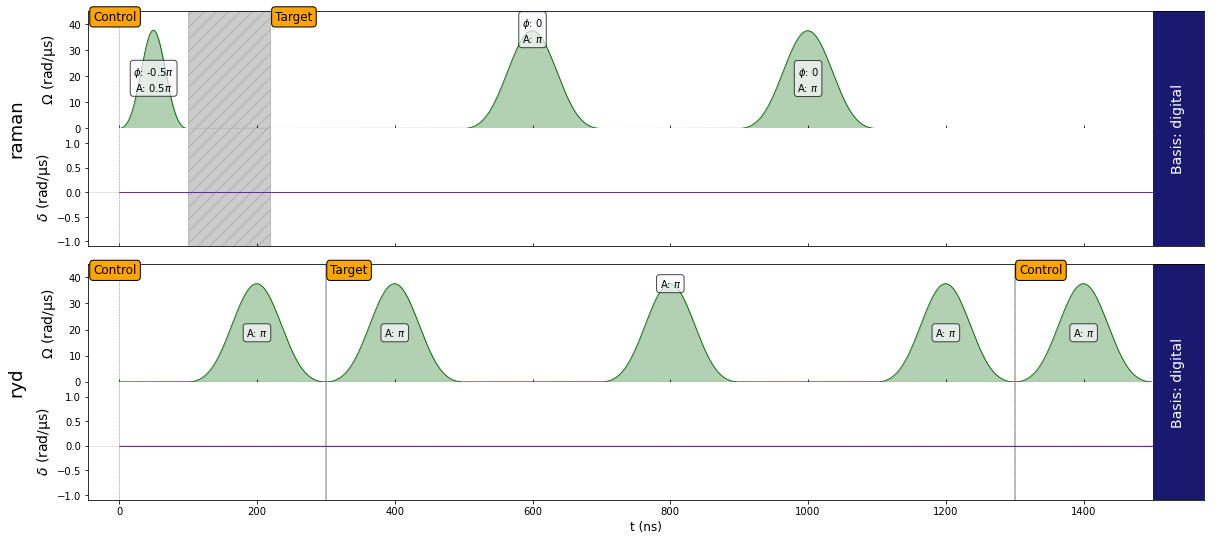

In [24]:
prep_state, prep_time = ENT('gg')
print(f'\nPrepared state-')
display(array_to_latex(prep_state))
print(f'\nPreparation time: {prep_time}ns\n')
print(f'Sequence:-\n{seq}')
print('\nPlot:-\n')
seq.draw(draw_phase_area=True)


## Simulating the Sequence
Let's define a function which combines all the functions defined above. This function takes state id as input, use `prep_state` function for state prepartion and `ENT` function for applying the entanglement sequence, and returns the sequence, its plot, prepared state, preapration time, counts after simulation, and plots a bar graph for these counts.

In [26]:
def Sim(sid, error=False):

    # State prep
    prep_state, prep_time = ENT(sid) # constructs seq, prep_state and prep_time
    
    print(f"\n\nOutput for the input state '{sid}':-\n\nPrepared state:")
    display(array_to_latex(prep_state))
    print(f'\nPreparation time: {prep_time}ns\n')

    # Construct Simulation instance
    sim = Simulation(seq)
    if (error==True):
        cfg = SimConfig(noise=('SPAM', 'doppler'), eta=1e-6, runs = 1000)
        sim.set_config(cfg)

    res = sim.run()
    final_state = res.get_final_state()

    count = res.sample_final_state(N_samples=1e3)
    print(f'\nCounts: {count}\n')
    
    display(plot_histogram(count))
    
    return final_state






Output for the input state 'gg':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 0ns


Counts: Counter({'11': 472, '00': 466, '01': 35, '10': 27})



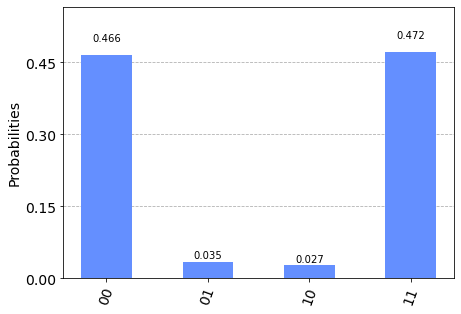



Output for the input state 'ge':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 200ns


Counts: Counter({'01': 472, '10': 465, '00': 49, '11': 14})



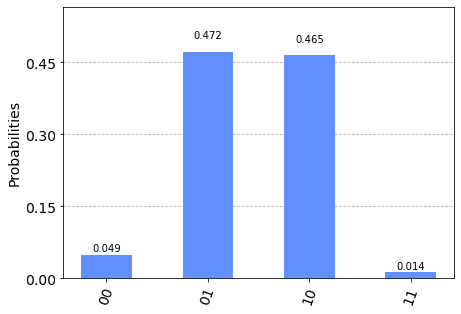

In [27]:
Output = []
for sid in ['gg','ge']:
    f = Sim(sid, error=True)
    Output.append(f)

## Output states
Let's see what are the output states in both the cases.

In [28]:
s = []
d = []
print('\n\nOutput:')
for i in range(len(Output)):
    x = np.sqrt(Output[i].diag())
    st = Statevector(x)
    dn = DensityMatrix(st)
    s.append(st)
    d.append(dn)
    print(f'\n\nStatevector for Bell state B{i+1}-')
    display(array_to_latex(s[i]))
    print(f'\nDensity matrix corressponding to this state-\n')
    display(array_to_latex(d[i]))




Output:


Statevector for Bell state B1-


<IPython.core.display.Latex object>


Density matrix corressponding to this state-



<IPython.core.display.Latex object>



Statevector for Bell state B2-


<IPython.core.display.Latex object>


Density matrix corressponding to this state-



<IPython.core.display.Latex object>


Visualizing density matrics:


For the Bell state B1-


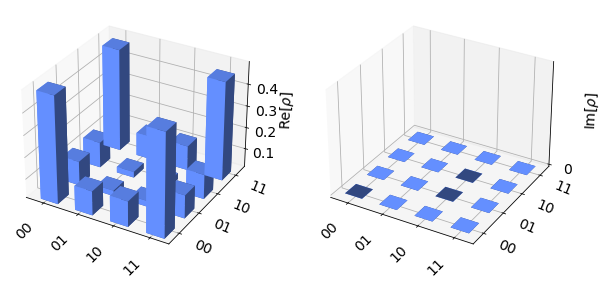


For the Bell state B2-


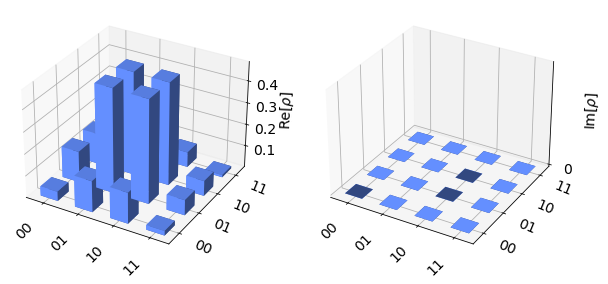

In [29]:
print('\nVisualizing density matrics:\n')
for i in range(len(Output)):
    print(f'\nFor the Bell state B{i+1}-')
    display(plot_state_city(d[i], figsize=[10,6]))

In [30]:
F = []

for i in range(2):
    p = d[i].to_dict()
    if (i==0):
        F.append((p['00|00']+p['11|11'])/2 + p['00|11'])
    else:
        F.append((p['01|01']+p['10|10'])/2 + p['10|01'])
        
for i in range(2):
    print(f'Fidelity for the Bell state B{i+1}: {F[i]}.\n')

Fidelity for the Bell state B1: (0.9464344596326995+0j).

Fidelity for the Bell state B2: (0.9467847483812719+0j).



## Entanglement verification and Fidelity


#### For the Bell state $B_1$

Input: `'00'`

$$
|B_1⟩ =  \frac{|00⟩ + |11⟩}{\sqrt{2}}
$$


The fidelity for state $B_1$ is given by:

$$
F = \frac{1}{2}(P_{00} + P_{11}) + c_1
$$

Where $c_1$ is the coherence between the |00⟩ and |11⟩ states. For the $F\leq 1/2$, the state can be written as a product state. So the value of $F$ larger than $1/2$ is an entangled state.


Density metrix:
$$ 𝝆_{00} = 
\begin{bmatrix}
  0.4706 & 0.1983 & 0.1711 & 0.4248 \\
  0.1983 & 0.0836 & 0.0721 & 0.1791 \\
  0.1711 & 0.0721 & 0.0622 & 0.1544 \\
  0.4248 & 0.1791 & 0.1544 & 0.3836  
\end{bmatrix}
$$

From density metrix, we get $ P_{00} = 0.4706 $, $ P_{11} = 0.3836 $, and $ c_1 = 0.4248$.

Hence, 

$$
F = \frac{1}{2}(0.4706 + 0.3836) + 0.4248 \\
\implies F = 0.8519
$$

#### For the Bell state $B_2$

Input: `'01'`

$$
|B_2⟩ =  \frac{|01⟩ + |10⟩}{\sqrt{2}}
$$


Similarly, the fidelity for the $B_2$ is given by:

$$
F = \frac{1}{2}(P_{01} + P_{10}) + c_2
$$

Where $c_2$ is the coherence between the |01⟩ and |10⟩ states.


Density metrix: 
$$ 𝝆_{01} =
\begin{bmatrix}
  0.1446 & 0.2418 & 0.2525 & 0.0376 \\
  0.2418 & 0.4046 & 0.4242 & 0.0629 \\
  0.2525 & 0.4224 & 0.4410 & 0.0657 \\
  0.0376 & 0.0629 & 0.0657 & 0.0098  
\end{bmatrix}
$$

From density metrix, we get $ P_{01} = 0.4046 $, $ P_{10} = 0.4410 $, and $ c_2 = 0.4224$.

Hence, 

$$
F = \frac{1}{2}(0.4046 + 0.4410) + 0.4224 \\
\implies F = 0.8452
$$

#### Result
We see that the value of $F$ is greater than $1/2$ in both the cases. So we can say that both the outputs are entangled states.

###### Ref: Demonstration of Rydberg Blockade, A Neutral Atom CNOT Gate, and Entanglement Generation by Larry Isenhower